In [1]:
!pip install kaggle dagshub mlflow -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 186MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [5]:
!unzip train.csv.zip
!unzip stores.csv.zip
!unzip features.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  test.csv.zip
  inflating: test.csv                


In [52]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import logging
import warnings
import cmdstanpy
import dagshub
import mlflow
import pickle
import joblib
from itertools import product
import sys
from io import StringIO

In [53]:
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

In [54]:
experiment_name = "Prophet_Training"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/723294fa9a3a4987bf90be420b0932f7', creation_time=1751228764096, experiment_id='1', last_update_time=1751228764096, lifecycle_stage='active', name='Prophet_Training', tags={}>

In [55]:
warnings.filterwarnings('ignore')
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
logging.getLogger('prophet.models').setLevel(logging.CRITICAL)

In [56]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [57]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [58]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [59]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1).rename(columns={'IsHoliday_x': 'IsHoliday'})

display(df.head())

In [60]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1).rename(columns={'IsHoliday_x': 'IsHoliday'})

# Evaluation Function

In [61]:
def WMAE(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday, 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# Preprocess

In [62]:
class ProphetDataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, use_regressors=True, lag_features=True):
        self.use_regressors = use_regressors
        self.lag_features = lag_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_prophet = X.copy()

        df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
        df_prophet = df_prophet.sort_values('ds')

        if self.use_regressors:
            if self.lag_features:
                df_prophet['Temperature_lag1'] = df_prophet['Temperature'].shift(1)
                df_prophet['Fuel_Price_lag1'] = df_prophet['Fuel_Price'].shift(1)
                df_prophet['CPI_lag1'] = df_prophet['CPI'].shift(1)
                df_prophet['Unemployment_lag1'] = df_prophet['Unemployment'].shift(1)

            df_prophet['Temperature_rolling_mean'] = df_prophet['Temperature'].rolling(window=4).mean()
            df_prophet['Fuel_Price_rolling_mean'] = df_prophet['Fuel_Price'].rolling(window=4).mean()

            df_prophet['Temp_Fuel_interaction'] = df_prophet['Temperature'] * df_prophet['Fuel_Price']

            df_prophet['IsHoliday_binary'] = df_prophet['IsHoliday'].astype(int)

        df_prophet = df_prophet.fillna(method='ffill').fillna(method='bfill')

        return df_prophet

    def get_params(self, deep=True):
        return {'use_regressors': self.use_regressors, 'lag_features': self.lag_features}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Training

In [63]:
class ProphetWrapper(BaseEstimator):
    def __init__(self,
                 yearly_seasonality=True,
                 weekly_seasonality=True,
                 daily_seasonality=False,
                 seasonality_mode='multiplicative',
                 changepoint_prior_scale=0.05,
                 seasonality_prior_scale=10.0,
                 holidays_prior_scale=10.0,
                 changepoint_range=0.8,
                 n_changepoints=25,
                 use_regressors=True,
                 regressor_params=None):

        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.seasonality_mode = seasonality_mode
        self.changepoint_prior_scale = changepoint_prior_scale
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.changepoint_range = changepoint_range
        self.n_changepoints = n_changepoints
        self.use_regressors = use_regressors
        self.regressor_params = regressor_params or {}

        self.model = None
        self.is_fitted = False

    def fit(self, X, y=None):
        old_stdout = sys.stdout
        sys.stdout = StringIO()

        try:
            self.model = Prophet(
                yearly_seasonality=self.yearly_seasonality,
                weekly_seasonality=self.weekly_seasonality,
                daily_seasonality=self.daily_seasonality,
                seasonality_mode=self.seasonality_mode,
                changepoint_prior_scale=self.changepoint_prior_scale,
                seasonality_prior_scale=self.seasonality_prior_scale,
                holidays_prior_scale=self.holidays_prior_scale,
                changepoint_range=self.changepoint_range,
                n_changepoints=self.n_changepoints,
                mcmc_samples=0,
                interval_width=0.80,
                uncertainty_samples=1000
            )

            if self.use_regressors:
                default_regressor_params = {'prior_scale': 10.0, 'standardize': True}

                regressors = [
                    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'
                ]

                for regressor in regressors:
                    if regressor in X.columns:
                        params = self.regressor_params.get(regressor, default_regressor_params)
                        self.model.add_regressor(regressor, **params)

            required_cols = ['ds', 'y']
            if self.use_regressors:
                regressor_cols = [col for col in X.columns if col not in ['ds', 'y']]
                required_cols.extend(regressor_cols)

            train_data = X[required_cols].dropna()

            self.model.fit(train_data)
            self.is_fitted = True

        finally:
            sys.stdout = old_stdout

        return self

    def predict(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        required_cols = ['ds']
        if self.use_regressors:
            regressor_cols = [col for col in X.columns if col not in ['ds', 'y']]
            required_cols.extend(regressor_cols)

        future = X[required_cols].copy()
        future = future.dropna()

        forecast = self.model.predict(future)
        return forecast['yhat'].values

    def predict_full(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        required_cols = ['ds']
        if self.use_regressors:
            regressor_cols = [col for col in X.columns if col not in ['ds', 'y']]
            required_cols.extend(regressor_cols)

        future = X[required_cols].copy()
        future = future.dropna()

        return self.model.predict(future)

    def get_params(self, deep=True):
        return {
            'yearly_seasonality': self.yearly_seasonality,
            'weekly_seasonality': self.weekly_seasonality,
            'daily_seasonality': self.daily_seasonality,
            'seasonality_mode': self.seasonality_mode,
            'changepoint_prior_scale': self.changepoint_prior_scale,
            'seasonality_prior_scale': self.seasonality_prior_scale,
            'holidays_prior_scale': self.holidays_prior_scale,
            'changepoint_range': self.changepoint_range,
            'n_changepoints': self.n_changepoints,
            'use_regressors': self.use_regressors,
            'regressor_params': self.regressor_params
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [64]:
def create_param_grid():
    param_grid = {
        'prophet__seasonality_mode': ['multiplicative'],
        'prophet__changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
        'prophet__seasonality_prior_scale': [1.0, 10.0, 100.0],
        'prophet__holidays_prior_scale': [1.0, 10.0, 100.0],
        'prophet__changepoint_range': [0.8, 0.9],
        'prophet__n_changepoints': [20, 25, 30],
        'prophet__yearly_seasonality': [True],
        'prophet__weekly_seasonality': [True,]
    }
    return param_grid

In [65]:
def create_prophet_pipeline():
    return Pipeline([
        ('preprocessor', ProphetDataPreprocessor()),
        ('prophet', ProphetWrapper())
    ])

In [66]:
def grid_search_for_combination(train_group, val_group, param_grid, max_combinations=50):
    param_combinations = list(ParameterGrid(param_grid))

    if len(param_combinations) > max_combinations:
        np.random.seed(42)
        param_combinations = np.random.choice(param_combinations, max_combinations, replace=False)

    best_params = None
    best_score = float('inf')
    best_pipeline = None
    best_results = None

    results = []

    for i, params in enumerate(param_combinations):
        try:
            pipeline = create_prophet_pipeline()
            pipeline.set_params(**params)

            pipeline.fit(train_group)

            train_predictions = pipeline.predict(train_group)
            val_predictions = pipeline.predict(val_group)

            train_wmae = WMAE(
                train_group['Weekly_Sales'].values,
                train_predictions,
                train_group['IsHoliday'].values
            )

            val_wmae = WMAE(
                val_group['Weekly_Sales'].values,
                val_predictions,
                val_group['IsHoliday'].values
            )

            overfitting_ratio = val_wmae / train_wmae if train_wmae > 0 else float('inf')

            result = {
                'params': params,
                'train_wmae': train_wmae,
                'val_wmae': val_wmae,
                'overfitting_ratio': overfitting_ratio,
                'train_mae': mean_absolute_error(train_group['Weekly_Sales'].values, train_predictions),
                'val_mae': mean_absolute_error(val_group['Weekly_Sales'].values, val_predictions)
            }
            results.append(result)

            if val_wmae < best_score:
                best_score = val_wmae
                best_params = params
                best_pipeline = pipeline
                best_results = result

        except Exception as e:
            print(f"Error with parameter combination {i}: {str(e)}")
            continue

    return best_pipeline, best_params, best_results, results

In [67]:
def create_analysis_plots(results_df, best_pipeline, best_combination, train_data, val_data):
    plt.figure(figsize=(20, 15))

    plt.subplot(2, 4, 1)
    plt.scatter(results_df['train_wmae'], results_df['val_wmae'], alpha=0.6)
    plt.plot([results_df['train_wmae'].min(), results_df['train_wmae'].max()],
             [results_df['train_wmae'].min(), results_df['train_wmae'].max()], 'r--', label='Perfect Fit')
    plt.xlabel('Training WMAE')
    plt.ylabel('Validation WMAE')
    plt.title('Training vs Validation WMAE')
    plt.legend()

    plt.subplot(2, 4, 2)
    plt.hist(results_df['overfitting_ratio'], bins=30, alpha=0.7)
    plt.axvline(x=1.0, color='g', linestyle='--', label='No Overfitting')
    plt.axvline(x=2.0, color='r', linestyle='--', label='Overfitting Threshold')
    plt.xlabel('Overfitting Ratio')
    plt.ylabel('Frequency')
    plt.title('Overfitting Distribution')
    plt.legend()

    plt.subplot(2, 4, 3)
    store_type_stats = results_df.groupby('Store_Type').agg({
        'train_wmae': 'mean',
        'val_wmae': 'mean'
    })

    x_pos = np.arange(len(store_type_stats.index))
    width = 0.35

    plt.bar(x_pos - width/2, store_type_stats['train_wmae'], width, label='Train WMAE', alpha=0.8)
    plt.bar(x_pos + width/2, store_type_stats['val_wmae'], width, label='Val WMAE', alpha=0.8)
    plt.xlabel('Store Type')
    plt.ylabel('Average WMAE')
    plt.title('Performance by Store Type')
    plt.xticks(x_pos, store_type_stats.index)
    plt.legend()

    plt.subplot(2, 4, 4)
    plt.hist(results_df['param_combinations_tested'], bins=20, alpha=0.7)
    plt.xlabel('Parameter Combinations Tested')
    plt.ylabel('Frequency')
    plt.title('Grid Search Coverage')

    plt.subplot(2, 4, 5)
    store, dept = best_combination
    best_train_data = train_data[(train_data['Store'] == store) & (train_data['Dept'] == dept)]
    best_val_data = val_data[(val_data['Store'] == store) & (val_data['Dept'] == dept)]

    preprocessed_val = best_pipeline['preprocessor'].transform(best_val_data)
    forecast = best_pipeline['prophet'].predict_full(preprocessed_val)

    plt.plot(best_train_data['Date'], best_train_data['Weekly_Sales'],
             label='Training Data', color='blue', alpha=0.7)
    plt.plot(best_val_data['Date'], best_val_data['Weekly_Sales'],
             label='Actual', color='green', marker='o', markersize=4)
    plt.plot(best_val_data['Date'], forecast['yhat'],
             label='Predicted', color='red', marker='s', markersize=4)
    plt.fill_between(best_val_data['Date'], forecast['yhat_lower'], forecast['yhat_upper'],
                     alpha=0.3, color='red', label='Confidence Interval')
    plt.title(f'Best Model: Store {store}, Dept {dept}')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.xticks(rotation=45)

    plt.subplot(2, 4, 6)
    plt.hist(results_df['val_wmae'], bins=30, alpha=0.7)
    plt.xlabel('Validation WMAE')
    plt.ylabel('Frequency')
    plt.title('Validation WMAE Distribution')

    plt.subplot(2, 4, 7)
    plt.scatter(results_df['Store_Size'], results_df['val_wmae'], alpha=0.6)
    plt.xlabel('Store Size')
    plt.ylabel('Validation WMAE')
    plt.title('Performance vs Store Size')

    plt.subplot(2, 4, 8)
    plt.scatter(results_df['Mean_Sales'], results_df['val_wmae'], alpha=0.6)
    plt.xlabel('Mean Sales')
    plt.ylabel('Validation WMAE')
    plt.title('Performance vs Mean Sales')

    plt.tight_layout()
    plt.savefig('prophet_grid_search_analysis.png', dpi=300, bbox_inches='tight')
    mlflow.log_artifact('prophet_grid_search_analysis.png')
    plt.show()

In [68]:
param_grid = create_param_grid()
max_param_combinations = 10

In [69]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Store', 'Dept', 'Date'])

In [70]:
train_data = df[df['Date'] < '2012-06-01'].copy()
val_data = df[df['Date'] >= '2012-06-01'].copy()

In [71]:
def filter_sufficient_data(group):
    return len(group) >= 60

In [72]:
valid_combinations = []
for (store, dept), group in train_data.groupby(['Store', 'Dept']):
    if filter_sufficient_data(group):
        val_group = val_data[(val_data['Store'] == store) & (val_data['Dept'] == dept)]
        if len(val_group) >= 8:
            valid_combinations.append((store, dept))

print(f"Processing {len(valid_combinations)} valid store-department combinations")

Processing 2923 valid store-department combinations


Processing combinations:  75%|███████▌  | 2199/2923 [1:22:52<25:00,  2.07s/it]

Error with parameter combination 0: Dataframe has no rows.
Error with parameter combination 1: Dataframe has no rows.
Error with parameter combination 2: Dataframe has no rows.
Error with parameter combination 3: Dataframe has no rows.
Error with parameter combination 4: Dataframe has no rows.
Error with parameter combination 5: Dataframe has no rows.
Error with parameter combination 6: Dataframe has no rows.
Error with parameter combination 7: Dataframe has no rows.
Error with parameter combination 8: Dataframe has no rows.


Processing combinations:  75%|███████▌  | 2200/2923 [1:23:00<45:22,  3.77s/it]

Error with parameter combination 9: Dataframe has no rows.


Processing combinations:  75%|███████▌  | 2205/2923 [1:23:11<32:21,  2.70s/it]

Error with parameter combination 0: Dataframe has no rows.
Error with parameter combination 1: Dataframe has no rows.
Error with parameter combination 2: Dataframe has no rows.
Error with parameter combination 3: Dataframe has no rows.
Error with parameter combination 4: Dataframe has no rows.
Error with parameter combination 5: Dataframe has no rows.
Error with parameter combination 6: Dataframe has no rows.
Error with parameter combination 7: Dataframe has no rows.
Error with parameter combination 8: Dataframe has no rows.


Processing combinations:  75%|███████▌  | 2206/2923 [1:23:15<36:35,  3.06s/it]

Error with parameter combination 9: Dataframe has no rows.


Processing combinations:  81%|████████▏ | 2380/2923 [1:30:02<24:18,  2.69s/it]

Error with parameter combination 0: Dataframe has no rows.
Error with parameter combination 1: Dataframe has no rows.
Error with parameter combination 2: Dataframe has no rows.
Error with parameter combination 3: Dataframe has no rows.
Error with parameter combination 4: Dataframe has no rows.
Error with parameter combination 5: Dataframe has no rows.
Error with parameter combination 6: Dataframe has no rows.
Error with parameter combination 7: Dataframe has no rows.


Processing combinations:  81%|████████▏ | 2381/2923 [1:30:03<21:13,  2.35s/it]

Error with parameter combination 8: Dataframe has no rows.
Error with parameter combination 9: Dataframe has no rows.


Processing combinations:  82%|████████▏ | 2394/2923 [1:30:31<18:49,  2.14s/it]

Error with parameter combination 0: Dataframe has no rows.
Error with parameter combination 1: Dataframe has no rows.
Error with parameter combination 2: Dataframe has no rows.
Error with parameter combination 3: Dataframe has no rows.
Error with parameter combination 4: Dataframe has no rows.
Error with parameter combination 5: Dataframe has no rows.
Error with parameter combination 6: Dataframe has no rows.
Error with parameter combination 7: Dataframe has no rows.
Error with parameter combination 8: Dataframe has no rows.


Processing combinations:  82%|████████▏ | 2395/2923 [1:30:37<29:17,  3.33s/it]

Error with parameter combination 9: Dataframe has no rows.


Processing combinations:  82%|████████▏ | 2409/2923 [1:31:05<17:03,  1.99s/it]

Error with parameter combination 0: Dataframe has no rows.
Error with parameter combination 1: Dataframe has no rows.
Error with parameter combination 2: Dataframe has no rows.
Error with parameter combination 3: Dataframe has no rows.
Error with parameter combination 4: Dataframe has no rows.
Error with parameter combination 5: Dataframe has no rows.
Error with parameter combination 6: Dataframe has no rows.
Error with parameter combination 7: Dataframe has no rows.


Processing combinations:  82%|████████▏ | 2410/2923 [1:31:07<15:11,  1.78s/it]

Error with parameter combination 8: Dataframe has no rows.
Error with parameter combination 9: Dataframe has no rows.


Processing combinations:  83%|████████▎ | 2420/2923 [1:31:28<19:07,  2.28s/it]

Error with parameter combination 0: Dataframe has no rows.
Error with parameter combination 1: Dataframe has no rows.
Error with parameter combination 2: Dataframe has no rows.
Error with parameter combination 3: Dataframe has no rows.
Error with parameter combination 4: Dataframe has no rows.
Error with parameter combination 5: Dataframe has no rows.
Error with parameter combination 6: Dataframe has no rows.
Error with parameter combination 7: Dataframe has no rows.


Processing combinations:  83%|████████▎ | 2421/2923 [1:31:33<27:09,  3.25s/it]

Error with parameter combination 8: Dataframe has no rows.
Error with parameter combination 9: Dataframe has no rows.


Processing combinations:  85%|████████▍ | 2471/2923 [1:33:26<22:50,  3.03s/it]

Error with parameter combination 0: Dataframe has no rows.
Error with parameter combination 1: Dataframe has no rows.
Error with parameter combination 2: Dataframe has no rows.
Error with parameter combination 3: Dataframe has no rows.
Error with parameter combination 4: Dataframe has no rows.
Error with parameter combination 5: Dataframe has no rows.
Error with parameter combination 6: Dataframe has no rows.
Error with parameter combination 7: Dataframe has no rows.
Error with parameter combination 8: Dataframe has no rows.


Processing combinations:  85%|████████▍ | 2472/2923 [1:33:32<28:21,  3.77s/it]

Error with parameter combination 9: Dataframe has no rows.


Processing combinations:  85%|████████▌ | 2493/2923 [1:34:25<13:59,  1.95s/it]

Error with parameter combination 0: Dataframe has no rows.
Error with parameter combination 1: Dataframe has no rows.
Error with parameter combination 2: Dataframe has no rows.
Error with parameter combination 3: Dataframe has no rows.
Error with parameter combination 4: Dataframe has no rows.
Error with parameter combination 5: Dataframe has no rows.
Error with parameter combination 6: Dataframe has no rows.
Error with parameter combination 7: Dataframe has no rows.
Error with parameter combination 8: Dataframe has no rows.


Processing combinations:  85%|████████▌ | 2494/2923 [1:34:26<12:27,  1.74s/it]

Error with parameter combination 9: Dataframe has no rows.


Processing combinations:  95%|█████████▌| 2781/2923 [1:45:27<06:16,  2.65s/it]

Error with parameter combination 0: Dataframe has no rows.
Error with parameter combination 1: Dataframe has no rows.
Error with parameter combination 2: Dataframe has no rows.
Error with parameter combination 3: Dataframe has no rows.
Error with parameter combination 4: Dataframe has no rows.
Error with parameter combination 5: Dataframe has no rows.
Error with parameter combination 6: Dataframe has no rows.
Error with parameter combination 7: Dataframe has no rows.
Error with parameter combination 8: Dataframe has no rows.


Processing combinations:  95%|█████████▌| 2782/2923 [1:45:32<08:02,  3.42s/it]

Error with parameter combination 9: Dataframe has no rows.


Processing combinations:  97%|█████████▋| 2835/2923 [1:47:36<05:33,  3.79s/it]

Error with parameter combination 0: Dataframe has no rows.
Error with parameter combination 1: Dataframe has no rows.
Error with parameter combination 2: Dataframe has no rows.
Error with parameter combination 3: Dataframe has no rows.
Error with parameter combination 4: Dataframe has no rows.
Error with parameter combination 5: Dataframe has no rows.
Error with parameter combination 6: Dataframe has no rows.
Error with parameter combination 7: Dataframe has no rows.
Error with parameter combination 8: Dataframe has no rows.


Processing combinations:  97%|█████████▋| 2836/2923 [1:47:37<04:37,  3.19s/it]

Error with parameter combination 9: Dataframe has no rows.


Processing combinations: 100%|██████████| 2923/2923 [1:50:40<00:00,  2.27s/it]


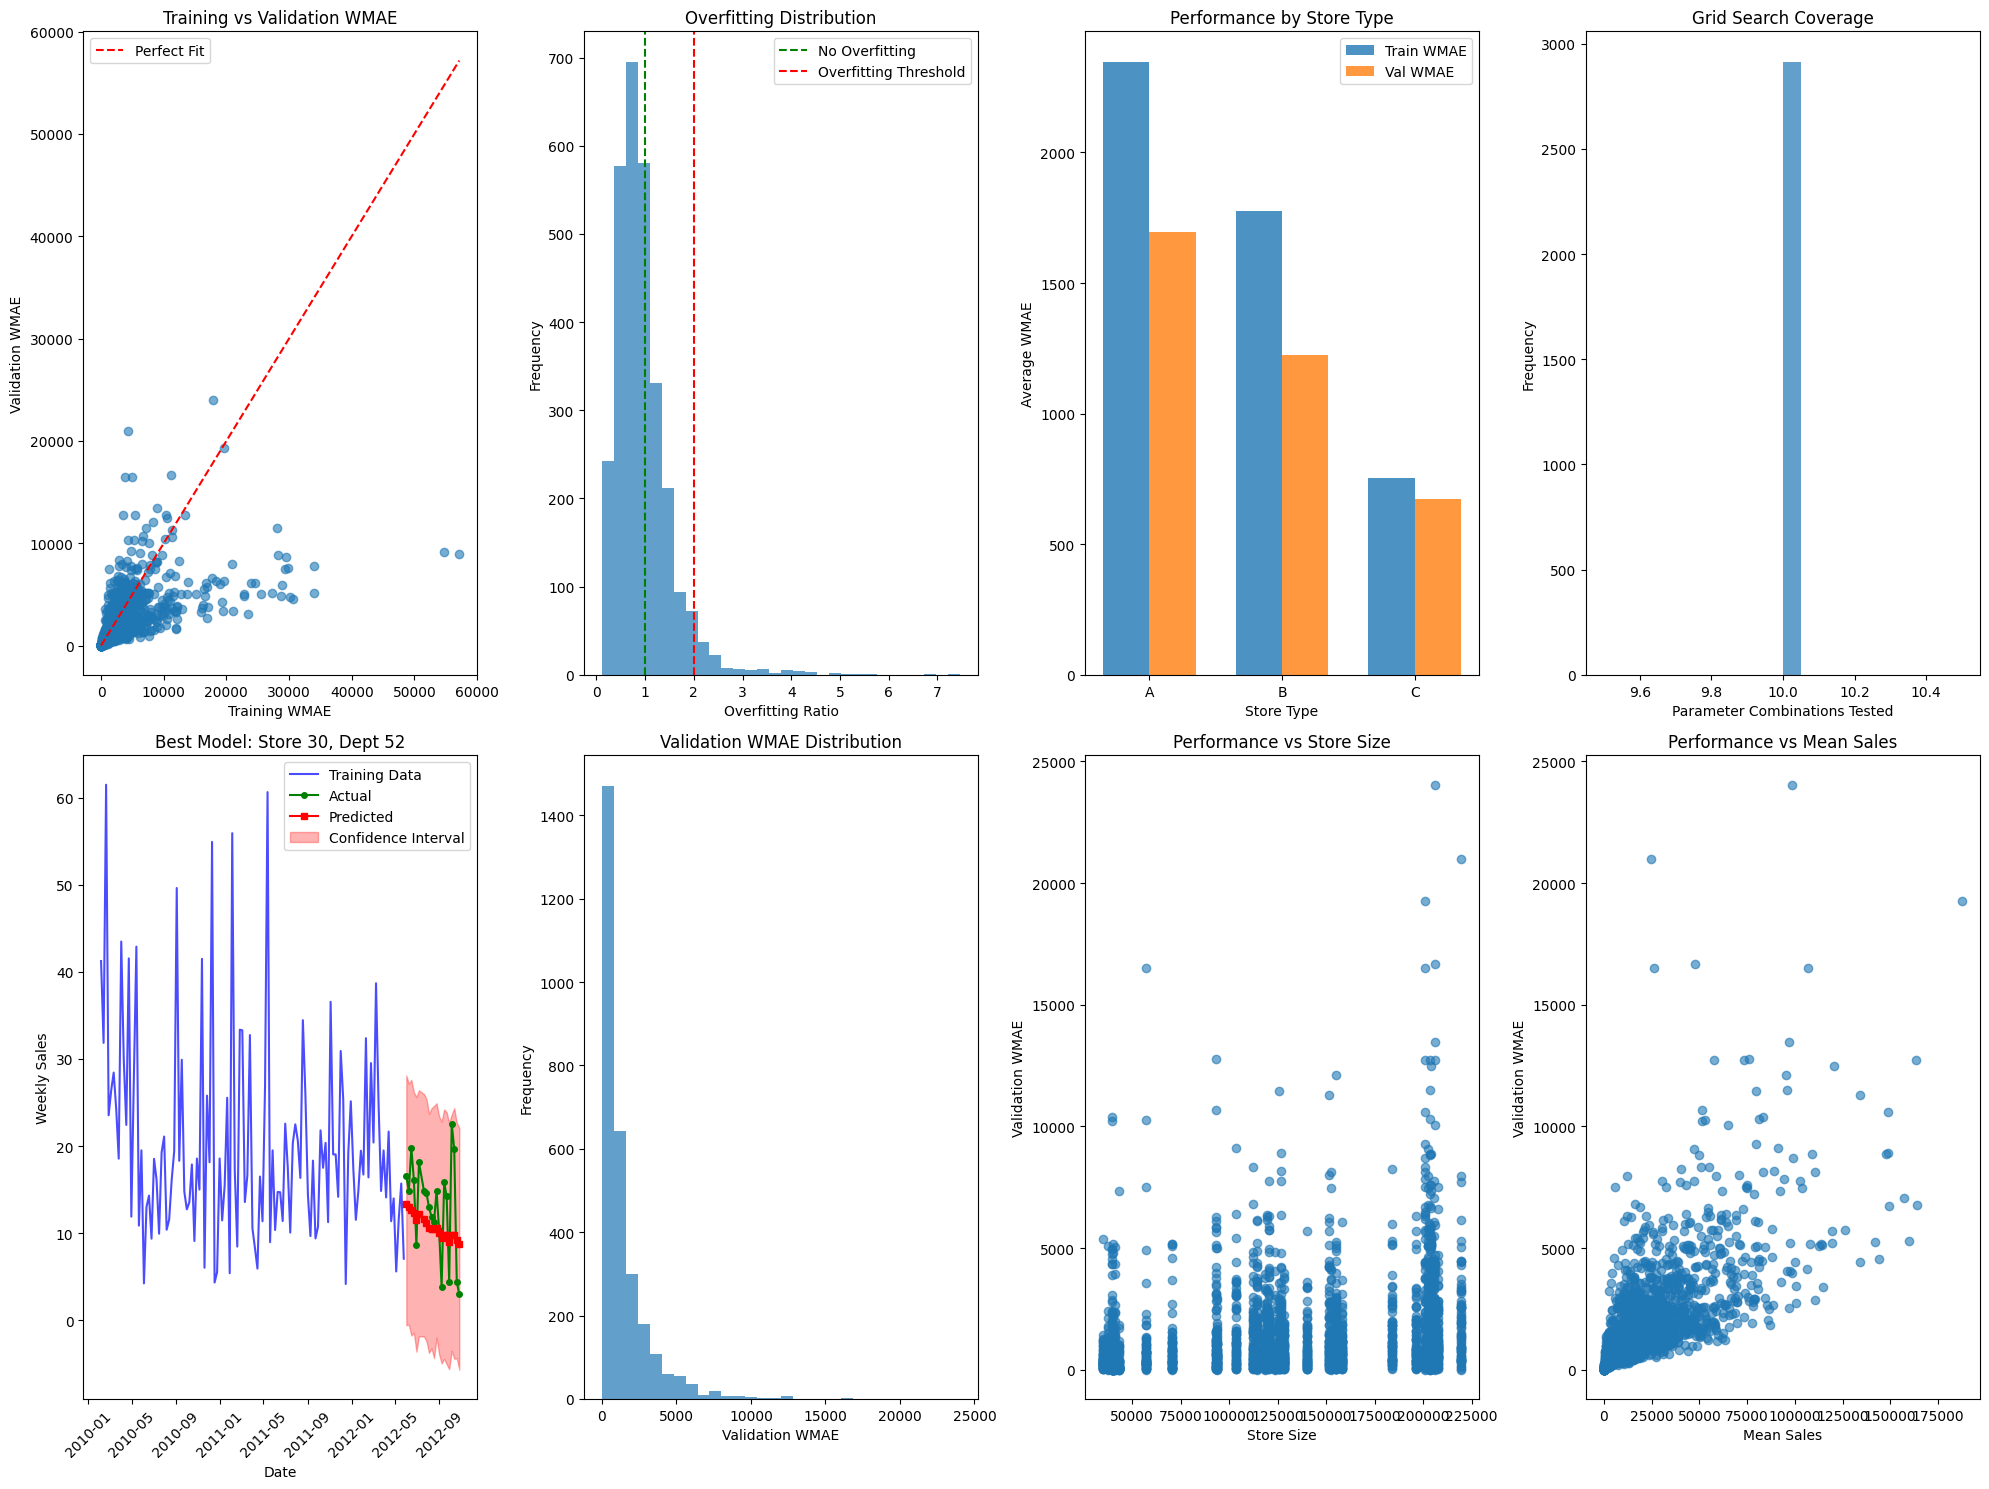

🏃 View run prophet_grid_search_hyperparams at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/1/runs/82636791cf46428c8283ec1d34b30c93
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/1
Training completed successfully!
Best parameters: {'preprocessor__lag_features': True, 'preprocessor__use_regressors': False, 'prophet__changepoint_prior_scale': 0.1, 'prophet__changepoint_range': 0.9, 'prophet__holidays_prior_scale': 100.0, 'prophet__n_changepoints': 25, 'prophet__seasonality_mode': 'multiplicative', 'prophet__seasonality_prior_scale': 1.0, 'prophet__weekly_seasonality': True, 'prophet__yearly_seasonality': False}
Results saved to MLflow with 2913 successful models


In [73]:
with mlflow.start_run(run_name="prophet_grid_search_hyperparams"):

    mlflow.log_param("model_type", "Prophet_Pipeline_GridSearch")
    mlflow.log_param("total_combinations", len(valid_combinations))
    mlflow.log_param("train_end_date", "2012-06-01")
    mlflow.log_param("min_train_size", 60)
    mlflow.log_param("min_val_size", 8)
    mlflow.log_param("max_param_combinations_per_model", max_param_combinations)
    mlflow.log_param("total_param_combinations", len(list(ParameterGrid(param_grid))))

    for param_name, param_values in param_grid.items():
        mlflow.log_param(f"grid_{param_name}", str(param_values))

    all_results = []
    best_global_score = float('inf')
    best_global_pipeline = None
    best_global_combination = None
    best_global_params = None

    for i, (store, dept) in enumerate(tqdm(valid_combinations, desc="Processing combinations")):
        try:
            train_group = train_data[(train_data['Store'] == store) & (train_data['Dept'] == dept)]
            val_group = val_data[(val_data['Store'] == store) & (val_data['Dept'] == dept)]

            if len(train_group) < 60 or len(val_group) < 8:
                continue

            best_pipeline, best_params, best_results, all_combo_results = grid_search_for_combination(
                train_group, val_group, param_grid, max_param_combinations
            )

            if best_pipeline is None:
                continue

            best_results['Store'] = store
            best_results['Dept'] = dept
            best_results['Train_Size'] = len(train_group)
            best_results['Val_Size'] = len(val_group)
            best_results['Mean_Sales'] = train_group['Weekly_Sales'].mean()
            best_results['Store_Type'] = train_group['Type'].iloc[0]
            best_results['Store_Size'] = train_group['Size'].iloc[0]
            best_results['param_combinations_tested'] = len(all_combo_results)

            all_results.append(best_results)

            if best_results['val_wmae'] < best_global_score:
                best_global_score = best_results['val_wmae']
                best_global_pipeline = best_pipeline
                best_global_combination = (store, dept)
                best_global_params = best_params

            if (i + 1) % 10 == 0:
                current_results = pd.DataFrame(all_results)
                mlflow.log_metric("avg_val_wmae_so_far", current_results['val_wmae'].mean(), step=i+1)
                mlflow.log_metric("best_val_wmae_so_far", current_results['val_wmae'].min(), step=i+1)
                mlflow.log_metric("avg_overfitting_ratio_so_far", current_results['overfitting_ratio'].mean(), step=i+1)

        except Exception as e:
            print(f"Error processing Store {store}, Dept {dept}: {str(e)}")
            continue

    if len(all_results) > 0:
        results_df = pd.DataFrame(all_results)

        mlflow.log_metric("final_avg_val_wmae", results_df['val_wmae'].mean())
        mlflow.log_metric("final_median_val_wmae", results_df['val_wmae'].median())
        mlflow.log_metric("final_best_val_wmae", results_df['val_wmae'].min())
        mlflow.log_metric("final_avg_overfitting_ratio", results_df['overfitting_ratio'].mean())
        mlflow.log_metric("total_successful_models", len(results_df))

        if best_global_pipeline is not None:
            mlflow.log_param("best_store", best_global_combination[0])
            mlflow.log_param("best_dept", best_global_combination[1])
            mlflow.log_metric("best_model_val_wmae", best_global_score)

            for param_name, param_value in best_global_params.items():
                mlflow.log_param(f"best_{param_name}", param_value)

            joblib.dump(best_global_pipeline, 'best_prophet_pipeline.pkl')
            mlflow.log_artifact('best_prophet_pipeline.pkl')

            create_analysis_plots(results_df, best_global_pipeline, best_global_combination,
                                train_data, val_data)

print("Training completed successfully!")
print(f"Best parameters: {best_global_params}")
print(f"Results saved to MLflow with {len(results_df)} successful models")